In [1]:
%matplotlib inline

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # how to import text vectorization in tf 2.3.0
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
import gensim
from gensim.models import Word2Vec
from keras.models import Model
from tensorflow.keras.layers import Embedding,Input,Dropout, LSTM, Bidirectional, \
    Conv1D, MaxPool1D, Dense, Attention, Flatten
from tensorflow.keras.models import Sequential

from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer



plt.style.use('seaborn')

## Models hyperparamters version 3

* maximum length of the sequences - we will not use the actual maximum length of the sequences as very few songs have 800 words in them. If we choose a maximum length equal to 300, we will cover 94% of the lyrics' actual length, if we choose 250 - we will cover 90%. We can try with 300, if we have a problem with the vanishing gradient - we can decrease it to 250 or even 200 (85%)



* maximum vocabulary size (word-based vocabulary) -  The set of unique words used in the text corpus is ~ 50 000. Given the fact that we work with lyrics of songs, even though we selected only English lyrics there is a high probability that there are some words left from Spanish ( typical for pop songs), some typical slang for artists, and other peculiarities. Thus we will use the maximum size of vocabulary 10 000 ( if it is too big, we can drop it to 5000) and keep only the most common words.




* BATCH_SIZE = 8 
* MAX_VOCABULARY_SIZE = 5000 
* MAX_OUTPUT_LENGTH = 200
* EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
* LEARNING_RATE = 1e-4 

In [51]:
TRAIN_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\train"
TEST_BASE_DIR = r"C:\Users\PC\Desktop\NN\Text calssification\test"
logs = r"C:\Users\PC\Desktop\NN\Text calssification\logs"
check_point_base = r"C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_base"
check_point_bi = r"C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi"
check_point_opt = r"C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt"
check_point_cnn = r"C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn"

N_CLASSES = 4

BATCH_SIZE = 8 # 16
MAX_VOCABULARY_SIZE = 5000 # change to 5000 if too big
MAX_OUTPUT_LENGTH = 200 # 300
EMBEDDING_DIMENSIONS = 100 #loaded GloVe trained  with 100d
LEARNING_RATE = 1e-4 # Adam default is 1e-3
Seed = 42

In [4]:

train_dataset = tf.keras.utils.text_dataset_from_directory(TRAIN_BASE_DIR,batch_size = BATCH_SIZE, validation_split=0.1,
    subset='training', seed = Seed)
   
   

Found 65048 files belonging to 4 classes.
Using 58544 files for training.


Found 65048 files belonging to 4 classes.
Using 58544 files for training.

In [5]:
print(train_dataset.cardinality().numpy())

7318


In [6]:
val_dataset = tf.keras.utils.text_dataset_from_directory(
    TRAIN_BASE_DIR, batch_size=BATCH_SIZE, validation_split=0.1,
    subset='validation', seed=Seed)

Found 65048 files belonging to 4 classes.
Using 6504 files for validation.


In [7]:
test_dataset = tf.keras.utils.text_dataset_from_directory(TEST_BASE_DIR,batch_size = BATCH_SIZE, seed = Seed)

Found 4000 files belonging to 4 classes.


In [8]:
### check the labesl
list(enumerate(train_dataset.class_names)), list(enumerate(val_dataset.class_names))

([(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')],
 [(0, 'Jazz'), (1, 'Metal'), (2, 'Pop'), (3, 'Rock')])

In [9]:
list(enumerate(train_dataset.class_names))[1]

(1, 'Metal')

.shape method in keras gives the lenght of a sequence

## Vectorizing the text

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

In [10]:
vectorize_layer = TextVectorization(
    max_tokens = MAX_VOCABULARY_SIZE, 
    output_sequence_length=MAX_OUTPUT_LENGTH)

In [11]:
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
### 76952 vocabulary size without limiting the vocabulary size to max size

In [13]:
#text_ds

In [14]:
vectorize_layer.vocabulary_size()

5000

In [15]:
## 1 is unkown

In [16]:
#vectorize_layer(["something nigga money where love queen king boy girl"])

In [17]:
### test
vectorize_layer.get_vocabulary()[4000:]


['rang',
 'liberate',
 'imitation',
 'harvest',
 'frail',
 'eminem',
 'ditch',
 'crucify',
 'carter',
 'carol',
 'canvas',
 'brief',
 'yelling',
 'village',
 'stunna',
 'slut',
 'rocker',
 'relation',
 'oooo',
 'moonlit',
 'max',
 'loco',
 'league',
 'kelly',
 'incomplete',
 'grinding',
 'donna',
 'diggin',
 'decline',
 'coulda',
 'argue',
 'tuck',
 'spiral',
 'raped',
 'poster',
 'pitter',
 'marie',
 'lucifer',
 'lettin',
 'howling',
 'gyal',
 'farmer',
 'crunk',
 'countin',
 'assume',
 'aisle',
 'actor',
 'yow',
 'western',
 'upstairs',
 'twerk',
 'tipsy',
 'tic',
 'suffocate',
 'stash',
 'stairway',
 'sideways',
 'ruler',
 'rooftop',
 'retreat',
 'permanent',
 'nurse',
 'jury',
 'fu',
 'finna',
 'dreamy',
 'declare',
 'daze',
 'collapse',
 'boyz',
 'asshole',
 'worldwide',
 'wage',
 'vibration',
 'sweetness',
 'strut',
 'snatch',
 'rail',
 'purse',
 'nameless',
 'mysterious',
 'melancholy',
 'meanwhile',
 'laura',
 'jo',
 'hustlin',
 'feature',
 'coin',
 'blondie',
 'beyonce',
 'rom

In [18]:
### test 
#output = vectorize_layer([["the cat sat on the mat"]])
#output.numpy()[0, :11]


In [19]:
# Here's a dict mapping words to their indices:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

5000

In [20]:
list(word_index.keys())[:20]

['',
 '[UNK]',
 'im',
 'love',
 'know',
 'dont',
 'like',
 'oh',
 'get',
 'got',
 'go',
 'one',
 'time',
 'youre',
 'never',
 'see',
 'let',
 'come',
 'cant',
 'baby']

In [21]:
tf.keras.backend.clear_session()

### Load Pretrained Glove Word Embedding

#Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.


GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


The GloVe model is trained on the non-zero entries of a global word-word co-occurrence matrix, which tabulates how frequently words co-occur with one another in a given corpus. Populating this matrix requires a single pass through the entire corpus to collect the statistics. For large corpora, this pass can be computationally expensive, but it is a one-time up-front cost. Subsequent training iterations are much faster because the number of non-zero matrix entries is typically much smaller than the total number of words in the corpus.

In [22]:
vectorize_layer.vocabulary_size()

5000

In [23]:
path_glove = (r'C:\Users\PC\Desktop\NN\NN Project\glove\glove.6B.100d.txt')

In [24]:
embeddings_index = {}
f = open(path_glove,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [25]:
#embeddings_index

#### Creating a weight matrix for words in training docs

In [26]:
### note to self 

#index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.
num_tokens = len(voc) + 2
embedding_dim = EMBEDDING_DIMENSIONS
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4925 words (75 misses)


In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41711   , -0.10176   ,  0.058147  , ..., -0.29444   ,
        -0.039114  ,  0.39534   ],
       ...,
       [-0.085527  , -0.24119   ,  0.22500999, ..., -0.39478999,
         0.45925   ,  0.49186   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Base LSTM Model

In [28]:
tf.keras.backend.clear_session()
model_name = "base lstm model"
checkpointer = ModelCheckpoint(filepath =check_point_base,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [ ]:
tf.keras.backend.clear_session()

In [29]:
lstm_base_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(128),
  Dense(N_CLASSES,activation = softmax)])

lstm_base_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [30]:
lstm_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          500200    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 617,964
Trainable params: 117,764
Non-trainable params: 500,200
_________________________________________________________________


In [31]:
lstm_history_base_model = lstm_base_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          verbose=1)

Epoch 1/10
7318/7318 [==============================] - 587s 80ms/step - loss: 1.2243 - acc: 0.4347 - val_loss: 1.1242 - val_acc: 0.5158
Epoch 2/10
7318/7318 [==============================] - 562s 77ms/step - loss: 1.1254 - acc: 0.5110 - val_loss: 1.0803 - val_acc: 0.5497
Epoch 3/10
7318/7318 [==============================] - 567s 78ms/step - loss: 1.0857 - acc: 0.5391 - val_loss: 1.0658 - val_acc: 0.5490
Epoch 4/10
7318/7318 [==============================] - 526s 72ms/step - loss: 1.0751 - acc: 0.5410 - val_loss: 1.0410 - val_acc: 0.5652
Epoch 5/10
7318/7318 [==============================] - 526s 72ms/step - loss: 1.0531 - acc: 0.5564 - val_loss: 1.0885 - val_acc: 0.5395
Epoch 6/10
7318/7318 [==============================] - 528s 72ms/step - loss: 1.0365 - acc: 0.5634 - val_loss: 1.0136 - val_acc: 0.5806
Epoch 7/10
7318/7318 [==============================] - 528s 72ms/step - loss: 1.0117 - acc: 0.5760 - val_loss: 1.0159 - val_acc: 0.5715
Epoch 8/10
7318/7318 [===================

In [32]:
def plot_loss_accuracy(hist,model):
    fig=plt.figure()
    plt.plot(hist.history['acc'],'r',linewidth=3.0)
    plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title(f'Accuracy Curves : {model}',fontsize=16)
    #fig.savefig('accuracy_lstm.png')
    plt.show()

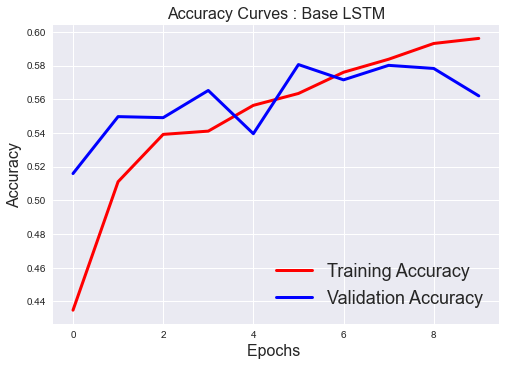

In [33]:
plot_loss_accuracy(lstm_history_base_model, 'Base LSTM')

In [34]:
_,val_acc = lstm_base_model.evaluate(val_dataset)

813/813 [==============================] - 15s 18ms/step - loss: 1.0289 - acc: 0.5620


In [35]:
hist_1 = pd.DataFrame(lstm_history_base_model.history)
hist_1['epoch'] = lstm_history_base_model.epoch

In [36]:
hist_1

,loss,acc,val_loss,val_acc,epoch
0,1.224348,0.434716,1.124247,0.515836,0
1,1.125438,0.511000,1.080331,0.549662,1
2,1.085680,0.539116,1.065817,0.549047,2
3,1.075124,0.541046,1.040990,0.565191,3
4,1.053140,0.556351,1.088536,0.539514,4
5,1.036480,0.563405,1.013636,0.580566,5
6,1.011730,0.575994,1.015861,0.571494,6
7,0.991166,0.583732,0.991625,0.580105,7
8,0.977535,0.593092,1.002160,0.578260,8
9,0.978641,0.596099,1.028889,0.561962,9


In [37]:
lstm_base_model.predict([''' 
It seems you're having some trouble In dealing with these changes Living with these changes (oh no) 
The world is a scary place Now that you've woken up the demon in me 
Why can't you just leave here and die Never stick your hand in my face again bitch
Fuck you
I don't need this shit

''' ])


1/1 [==============================] - 1s 627ms/step


array([[0.06087403, 0.33457008, 0.19296125, 0.41159454]], dtype=float32)

In [ ]:
train_dataset.class_names

## Optimize base LSTM

In [38]:
tf.keras.backend.clear_session()

In [39]:
model_name = "optimized lstm model"
checkpointer_opt = ModelCheckpoint(filepath =check_point_opt,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_opt = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [40]:
lstm_opt_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  LSTM(64,return_sequences=True,dropout=0.2),
  tf.keras.layers.GlobalMaxPooling1D(),
  Dense(64,activation='relu'),
  Dense(N_CLASSES,activation = softmax)])

lstm_opt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [41]:
lstm_opt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          500200    
                                                                 
 lstm (LSTM)                 (None, 200, 64)           42240     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [42]:
lstm_history_opt_model = lstm_opt_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer_opt, early_stopping_opt])

Epoch 1/10
7317/7318 [============================>.] - ETA: 0s - loss: 1.1115 - acc: 0.5100

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 330s 45ms/step - loss: 1.1116 - acc: 0.5100 - val_loss: 1.0270 - val_acc: 0.5695
Epoch 2/10
7318/7318 [==============================] - ETA: 0s - loss: 1.0104 - acc: 0.5711

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 322s 44ms/step - loss: 1.0104 - acc: 0.5711 - val_loss: 0.9996 - val_acc: 0.5758
Epoch 3/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9804 - acc: 0.5871

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 388s 53ms/step - loss: 0.9804 - acc: 0.5871 - val_loss: 0.9749 - val_acc: 0.5881
Epoch 4/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9598 - acc: 0.5965

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 344s 47ms/step - loss: 0.9598 - acc: 0.5965 - val_loss: 0.9526 - val_acc: 0.5996
Epoch 5/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9446 - acc: 0.6038

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 367s 50ms/step - loss: 0.9446 - acc: 0.6038 - val_loss: 0.9416 - val_acc: 0.6076
Epoch 6/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9302 - acc: 0.6110

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 381s 52ms/step - loss: 0.9302 - acc: 0.6110 - val_loss: 0.9257 - val_acc: 0.6153
Epoch 7/10
7317/7318 [============================>.] - ETA: 0s - loss: 0.9200 - acc: 0.6160

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 376s 51ms/step - loss: 0.9200 - acc: 0.6160 - val_loss: 0.9251 - val_acc: 0.6133
Epoch 8/10
7317/7318 [============================>.] - ETA: 0s - loss: 0.9091 - acc: 0.6206

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 364s 50ms/step - loss: 0.9091 - acc: 0.6206 - val_loss: 0.9170 - val_acc: 0.6218
Epoch 9/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9013 - acc: 0.6242

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 389s 53ms/step - loss: 0.9013 - acc: 0.6242 - val_loss: 0.9141 - val_acc: 0.6193
Epoch 10/10
7317/7318 [============================>.] - ETA: 0s - loss: 0.8923 - acc: 0.6303

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_opt\assets


7318/7318 [==============================] - 367s 50ms/step - loss: 0.8923 - acc: 0.6303 - val_loss: 0.9163 - val_acc: 0.6238


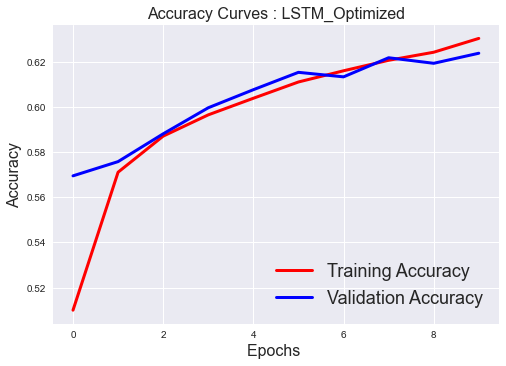

In [43]:
plot_loss_accuracy(lstm_history_opt_model, 'LSTM_Optimized')

In [44]:
_,val_acc = lstm_opt_model.evaluate(val_dataset)

813/813 [==============================] - 11s 14ms/step - loss: 0.9163 - acc: 0.6238


In [45]:
hist_2 = pd.DataFrame(lstm_history_opt_model.history)
hist_2['epoch'] = lstm_history_opt_model.epoch

In [46]:
hist_2

,loss,acc,val_loss,val_acc,epoch
0,1.111551,0.510027,1.026981,0.569496,0
1,1.010440,0.571109,0.999582,0.575800,1
2,0.980429,0.587080,0.974940,0.588100,2
3,0.959794,0.596492,0.952604,0.599631,3
4,0.944569,0.603836,0.941639,0.607626,4
5,0.930207,0.611045,0.925666,0.615314,5
6,0.920017,0.615998,0.925063,0.613315,6
7,0.909100,0.620644,0.917006,0.621771,7
8,0.901291,0.624214,0.914137,0.619311,8
9,0.892290,0.630329,0.916274,0.623770,9


## Bidirectional LSTM

In [74]:
tf.keras.backend.clear_session()

In [53]:
model_name = "optimized lstm model"
checkpointer_bi = ModelCheckpoint(filepath =check_point_bi,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_bi = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [55]:
lstm_bi_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Bidirectional(LSTM(128)),
  
  Dense(N_CLASSES, activation = softmax)
  ])

lstm_bi_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"])

In [56]:
lstm_bi_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          500200    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 735,724
Trainable params: 235,524
Non-trainable params: 500,200
_________________________________________________________________


In [57]:
lstm_history_bi_model = lstm_bi_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          callbacks=[checkpointer_bi, early_stopping_bi])

Epoch 1/10
7318/7318 [==============================] - ETA: 0s - loss: 1.0746 - acc: 0.5357

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 633s 86ms/step - loss: 1.0746 - acc: 0.5357 - val_loss: 1.0328 - val_acc: 0.5664
Epoch 2/10
7318/7318 [==============================] - ETA: 0s - loss: 1.0004 - acc: 0.5752

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 637s 87ms/step - loss: 1.0004 - acc: 0.5752 - val_loss: 0.9933 - val_acc: 0.5878
Epoch 3/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9709 - acc: 0.5930

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 640s 88ms/step - loss: 0.9709 - acc: 0.5930 - val_loss: 0.9725 - val_acc: 0.5944
Epoch 4/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9469 - acc: 0.6035

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 689s 94ms/step - loss: 0.9469 - acc: 0.6035 - val_loss: 0.9574 - val_acc: 0.5962
Epoch 5/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9273 - acc: 0.6126

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 703s 96ms/step - loss: 0.9273 - acc: 0.6126 - val_loss: 0.9432 - val_acc: 0.6027
Epoch 6/10
7318/7318 [==============================] - ETA: 0s - loss: 0.9081 - acc: 0.6210

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 976s 133ms/step - loss: 0.9081 - acc: 0.6210 - val_loss: 0.9428 - val_acc: 0.6026
Epoch 7/10
7318/7318 [==============================] - ETA: 0s - loss: 0.8913 - acc: 0.6292

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 983s 134ms/step - loss: 0.8913 - acc: 0.6292 - val_loss: 0.9336 - val_acc: 0.6095
Epoch 8/10
7318/7318 [==============================] - ETA: 0s - loss: 0.8746 - acc: 0.6359

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 995s 136ms/step - loss: 0.8746 - acc: 0.6359 - val_loss: 0.9208 - val_acc: 0.6172
Epoch 9/10
7318/7318 [==============================] - ETA: 0s - loss: 0.8586 - acc: 0.6441

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 1148s 157ms/step - loss: 0.8586 - acc: 0.6441 - val_loss: 0.9305 - val_acc: 0.6089
Epoch 10/10
7318/7318 [==============================] - ETA: 0s - loss: 0.8411 - acc: 0.6518

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_bi\assets


7318/7318 [==============================] - 1276s 174ms/step - loss: 0.8411 - acc: 0.6518 - val_loss: 0.9224 - val_acc: 0.6149


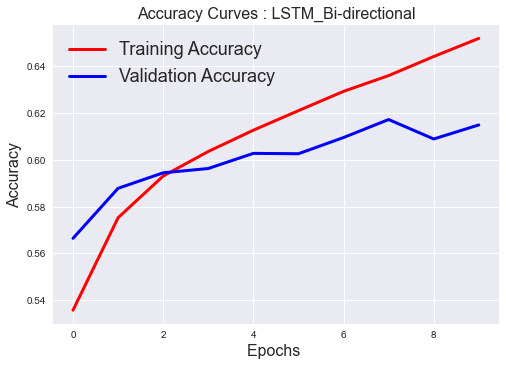

In [58]:
plot_loss_accuracy(lstm_history_bi_model, 'LSTM_Bi-directional')

In [59]:
_,val_acc = lstm_bi_model.evaluate(val_dataset)

813/813 [==============================] - 42s 52ms/step - loss: 0.9224 - acc: 0.6149


In [60]:
hist_3 = pd.DataFrame(lstm_history_bi_model.history)
hist_3['epoch'] = lstm_history_bi_model.epoch

In [61]:
hist_3

,loss,acc,val_loss,val_acc,epoch
0,1.074649,0.535734,1.032842,0.566421,0
1,1.000390,0.575225,0.993276,0.587792,1
2,0.970889,0.593024,0.972472,0.594403,2
3,0.946913,0.603512,0.957410,0.596248,3
4,0.927286,0.612599,0.943224,0.602706,4
5,0.908087,0.620952,0.942849,0.602552,5
6,0.891256,0.629185,0.933594,0.609471,6
7,0.874620,0.635915,0.920810,0.617159,7
8,0.858552,0.644063,0.930525,0.608856,8
9,0.841074,0.651800,0.922365,0.614852,9


## CNN model

In [85]:
tf.keras.backend.clear_session()

In [86]:
checkpointer_cnn = ModelCheckpoint(filepath =check_point_cnn,
                               save_best_only=False, save_weights_only = False, verbose=0,mode='min')
early_stopping_cnn = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [87]:
cnn_model = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Conv1D(128,3, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
 
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  Dropout(0.2),
  
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(N_CLASSES, activation = softmax)
  ])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [88]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          500200    
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          8

In [89]:
cnn_history_model = cnn_model.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 20,
          callbacks=[checkpointer_cnn, early_stopping_cnn])

Epoch 1/20
7317/7318 [============================>.] - ETA: 0s - loss: 1.0890 - acc: 0.5276

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 164s 22ms/step - loss: 1.0890 - acc: 0.5276 - val_loss: 1.0292 - val_acc: 0.5744
Epoch 2/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.9882 - acc: 0.5826

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.9882 - acc: 0.5826 - val_loss: 0.9667 - val_acc: 0.6073
Epoch 3/20
7317/7318 [============================>.] - ETA: 0s - loss: 0.9373 - acc: 0.6097

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 164s 22ms/step - loss: 0.9373 - acc: 0.6097 - val_loss: 0.9485 - val_acc: 0.6122
Epoch 4/20
7318/7318 [==============================] - ETA: 0s - loss: 0.8981 - acc: 0.6269

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.8981 - acc: 0.6269 - val_loss: 0.9284 - val_acc: 0.6142
Epoch 5/20
7318/7318 [==============================] - ETA: 0s - loss: 0.8674 - acc: 0.6406

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.8674 - acc: 0.6406 - val_loss: 0.9233 - val_acc: 0.6162
Epoch 6/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.8385 - acc: 0.6546

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.8385 - acc: 0.6546 - val_loss: 0.9212 - val_acc: 0.6162
Epoch 7/20
7317/7318 [============================>.] - ETA: 0s - loss: 0.8109 - acc: 0.6671

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.8110 - acc: 0.6671 - val_loss: 0.9126 - val_acc: 0.6227
Epoch 8/20
7318/7318 [==============================] - ETA: 0s - loss: 0.7866 - acc: 0.6784

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.7866 - acc: 0.6784 - val_loss: 0.9050 - val_acc: 0.6301
Epoch 9/20
7317/7318 [============================>.] - ETA: 0s - loss: 0.7657 - acc: 0.6855

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 164s 22ms/step - loss: 0.7657 - acc: 0.6855 - val_loss: 0.9194 - val_acc: 0.6232
Epoch 10/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.7423 - acc: 0.6994

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.7423 - acc: 0.6994 - val_loss: 0.9132 - val_acc: 0.6218
Epoch 11/20
7318/7318 [==============================] - ETA: 0s - loss: 0.7186 - acc: 0.7073

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 164s 22ms/step - loss: 0.7186 - acc: 0.7073 - val_loss: 0.9210 - val_acc: 0.6184
Epoch 12/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.6997 - acc: 0.7168

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 164s 22ms/step - loss: 0.6997 - acc: 0.7167 - val_loss: 0.9063 - val_acc: 0.6310
Epoch 13/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.6817 - acc: 0.7250

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.6818 - acc: 0.7250 - val_loss: 0.9290 - val_acc: 0.6241
Epoch 14/20
7317/7318 [============================>.] - ETA: 0s - loss: 0.6662 - acc: 0.7329

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.6662 - acc: 0.7329 - val_loss: 0.9212 - val_acc: 0.6255
Epoch 15/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.6456 - acc: 0.7392

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 163s 22ms/step - loss: 0.6456 - acc: 0.7392 - val_loss: 0.9418 - val_acc: 0.6196
Epoch 16/20
7318/7318 [==============================] - ETA: 0s - loss: 0.6349 - acc: 0.7456

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 165s 23ms/step - loss: 0.6349 - acc: 0.7456 - val_loss: 0.9367 - val_acc: 0.6182
Epoch 17/20
7317/7318 [============================>.] - ETA: 0s - loss: 0.6176 - acc: 0.7523

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 159s 22ms/step - loss: 0.6177 - acc: 0.7523 - val_loss: 0.9400 - val_acc: 0.6241
Epoch 18/20
7316/7318 [============================>.] - ETA: 0s - loss: 0.6042 - acc: 0.7564

INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


INFO:tensorflow:Assets written to: C:\Users\PC\Desktop\NN\Text calssification\version 3\checkpoint_cnn\assets


7318/7318 [==============================] - 161s 22ms/step - loss: 0.6042 - acc: 0.7564 - val_loss: 0.9495 - val_acc: 0.6187


In [90]:
_,val_acc = cnn_model.evaluate(val_dataset)

813/813 [==============================] - 6s 8ms/step - loss: 0.9495 - acc: 0.6187


In [91]:
hist_4 = pd.DataFrame(cnn_history_model.history)
hist_4['epoch'] = cnn_history_model.epoch

In [92]:
hist_4

,loss,acc,val_loss,val_acc,epoch
0,1.088978,0.527552,1.029178,0.574416,0
1,0.988219,0.582553,0.966693,0.607319,1
2,0.937312,0.609678,0.948529,0.612239,2
3,0.898087,0.626930,0.928385,0.614237,3
4,0.867384,0.640595,0.923340,0.616236,4
5,0.838546,0.654567,0.921243,0.616236,5
6,0.810951,0.667054,0.912575,0.622694,6
7,0.786583,0.678413,0.905049,0.630074,7
8,0.765682,0.685502,0.919371,0.623155,8
9,0.742291,0.699389,0.913168,0.621771,9


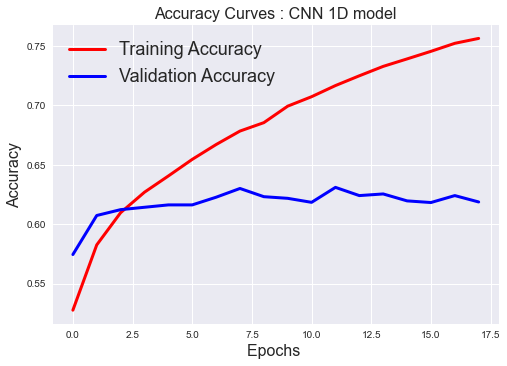

In [93]:
plot_loss_accuracy(cnn_history_model, 'CNN 1D model')

With batch 8, learning rate 1e-4, vocabulary 5000 and max sequence lenght - the model starts to overfit.

### CNN model no drop out

In [78]:
cnn_model_2 = Sequential([
  vectorize_layer,
  Embedding(input_dim = vectorize_layer.vocabulary_size()+2, output_dim = EMBEDDING_DIMENSIONS,weights=[embedding_matrix],input_length=MAX_OUTPUT_LENGTH,trainable=False),
  Conv1D(128,3, padding = 'same', activation= 'relu'),
  MaxPool1D(),
 
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  
  
  Conv1D(128,5, padding = 'same', activation= 'relu'),
  MaxPool1D(),
  
  
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(N_CLASSES, activation = softmax)
  ])

cnn_model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate = LEARNING_RATE),
    metrics = ["acc"]
    )

In [79]:
cnn_history_model_2 = cnn_model_2.fit(train_dataset, 
          validation_data = val_dataset,
          epochs = 10,
          verbose=1)

Epoch 1/10
7318/7318 [==============================] - 145s 20ms/step - loss: 1.0585 - acc: 0.5432 - val_loss: 1.0050 - val_acc: 0.5789
Epoch 2/10
7318/7318 [==============================] - 142s 19ms/step - loss: 0.9401 - acc: 0.6061 - val_loss: 0.9498 - val_acc: 0.6041
Epoch 3/10
7318/7318 [==============================] - 143s 20ms/step - loss: 0.8531 - acc: 0.6465 - val_loss: 0.9656 - val_acc: 0.6030
Epoch 4/10
7318/7318 [==============================] - 143s 20ms/step - loss: 0.7524 - acc: 0.6958 - val_loss: 0.9912 - val_acc: 0.5970
Epoch 5/10
7318/7318 [==============================] - 144s 20ms/step - loss: 0.6333 - acc: 0.7519 - val_loss: 1.0833 - val_acc: 0.5829
Epoch 6/10
7318/7318 [==============================] - 142s 19ms/step - loss: 0.5102 - acc: 0.8081 - val_loss: 1.1728 - val_acc: 0.5798
Epoch 7/10
7318/7318 [==============================] - 145s 20ms/step - loss: 0.3902 - acc: 0.8615 - val_loss: 1.3450 - val_acc: 0.5690
Epoch 8/10
7318/7318 [===================

In [82]:
_,val_acc = cnn_model_2.evaluate(val_dataset)

813/813 [==============================] - 7s 8ms/step - loss: 1.9684 - acc: 0.5467


In [83]:
hist_5 = pd.DataFrame(cnn_history_model.history)
hist_5['epoch'] = cnn_history_model_2.epoch

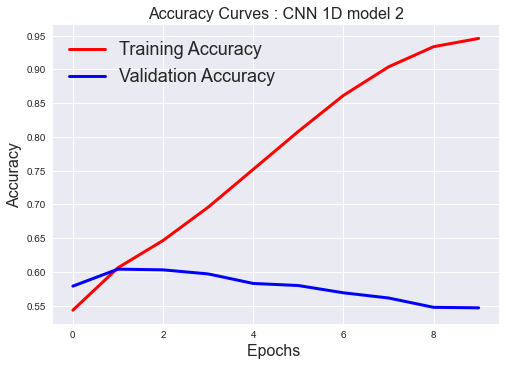

In [84]:
plot_loss_accuracy(cnn_history_model_2, 'CNN 1D model 2')